In [2]:
from elasticsearch import Elasticsearch, helpers
from pprint import pp
import pandas as pd
from tqdm import tqdm
import os

def ppr(resp):
    pp(resp.raw)

In [12]:
def pretty_search_response_semantic(response):
    if len(response["hits"]["hits"]) == 0:
        print("Your search returned no results.")
    else:
        for hit in response["hits"]["hits"]:
            score = hit["_score"]
            title = hit["_source"]["Title"]

            pretty_output = f"Score: {score}\nTitle: {title}\n"

            print(pretty_output)


def pretty_search_response(response):
    if len(response["hits"]["hits"]) == 0:
        print("Your search returned no results.")
    else:
        for hit in response["hits"]["hits"]:
            id = hit["_id"]
            score = hit["_score"]
            body = hit["_source"]["Body"]
            comment_count = hit["_source"]["CommentCount"]
            creation_date = hit["_source"]["CreationDate"]

            pretty_output = f"\nID: {id}\nScore: {score}\nBody: {body}\nCommentCount: {comment_count}\nCreationDate: {creation_date}"

            print(pretty_output)

In [5]:
es = Elasticsearch(
    hosts=[
        "http://localhost:9200" 
    ],
    verify_certs=False,
)

In [6]:
if es.ping():
    print("Connected to Elasticsearch!")
else:
    print("Could not connect to Elasticsearch.")

Connected to Elasticsearch!


In [5]:
es.cat.health(v=True)

TextApiResponse('epoch      timestamp cluster           status node.total node.data shards pri relo init unassign unassign.pri pending_tasks max_task_wait_time active_shards_percent\n1734257167 10:06:07  es-docker-cluster green           3         3     12  12    0    0        0            0             0                  -                100.0%\n')

In [32]:
es.indices.delete(index='html_posts', ignore_unavailable=True)

es.indices.create(
    index='html_posts',
    settings={
        "number_of_shards": 6,
        "number_of_replicas": 0,
        "analysis": {
            "analyzer": {
                "html_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "char_filter": [
                        "html_strip"
                    ]
                }
            }
        }
    }, 
    mappings={
        "properties": {
            "Body": {
                "type": "text",
                "analyzer": "html_analyzer"
            },
            "CommentCount": {
                "type": "integer"
            },
            "CreationDate": {
                "type": "date",
                "format": "yyyy-MM-dd HH:mm:ss.SSS"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'html_posts'})

In [8]:
def generator(json_chunk):
    for line in json_chunk:
        yield {
            "_index": "html_posts",
            "_id": line.get('Id'),
            "_source": {
                "Body": line.get("Body",""),
                "CommentCount": line.get("CommentCount",""),
                "CreationDate": line.get("CreationDate","")
            }
        }


def from_chunk_to_es(chunk):
    json_chunk = chunk.to_dict("records")
    return generator(json_chunk)

In [9]:
columns = ['Id', 'Body', 'CommentCount', "CreationDate"]

for chunk in tqdm(pd.read_csv('../data/StackOverflowMini_dbo_Posts.csv', chunksize=1000)):
    gen = from_chunk_to_es(chunk[columns])
    res = helpers.bulk(es, gen)

1566it [02:03, 12.73it/s]


In [33]:
print(list(es.nodes.stats()['nodes'].values())[2]['indices'])

{'docs': {'count': 0, 'deleted': 0, 'total_size_in_bytes': 0}, 'shard_stats': {'total_count': 6}, 'store': {'size_in_bytes': 1450, 'total_data_set_size_in_bytes': 1450, 'reserved_in_bytes': 0}, 'indexing': {'index_total': 1571665, 'index_time_in_millis': 132458, 'index_current': 0, 'index_failed': 0, 'delete_total': 0, 'delete_time_in_millis': 0, 'delete_current': 0, 'noop_update_total': 0, 'is_throttled': False, 'throttle_time_in_millis': 0, 'write_load': 0.005117832428672113}, 'get': {'total': 0, 'time_in_millis': 0, 'exists_total': 0, 'exists_time_in_millis': 0, 'missing_total': 0, 'missing_time_in_millis': 0, 'current': 0}, 'search': {'open_contexts': 0, 'query_total': 36, 'query_time_in_millis': 115, 'query_current': 0, 'query_failure': 0, 'fetch_total': 2, 'fetch_time_in_millis': 46, 'fetch_current': 0, 'fetch_failure': 0, 'scroll_total': 0, 'scroll_time_in_millis': 0, 'scroll_current': 0, 'suggest_total': 0, 'suggest_time_in_millis': 0, 'suggest_current': 0}, 'merges': {'current

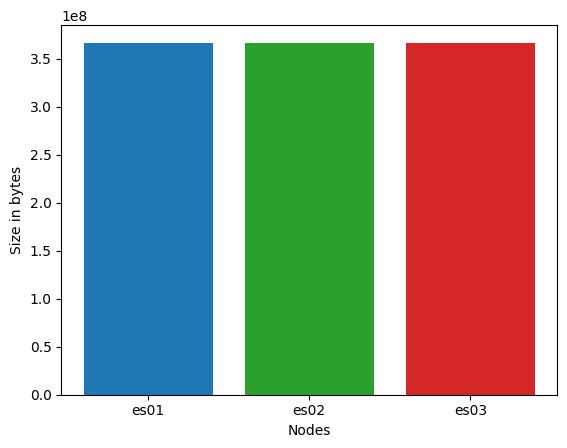

In [18]:
import matplotlib.pyplot as plt
plt.style.use("default")

counts = []
sizes = []
colors = ['tab:blue', 'tab:green', 'tab:red']
for node in es.nodes.stats()['nodes'].values():
    counts.append(node['indices']['docs']['count'])
    sizes.append(node['indices']['docs']['total_size_in_bytes'])

plt.bar(x=["es01", "es02", "es03"], height=sizes, color=colors)
plt.xlabel("Nodes")
plt.ylabel("Size in bytes")
plt.savefig("load_balancing.png")
plt.show()

In [12]:
# effects of analyzer
resp = es.search(
    index="html_posts",
    size="3",
    query={
        "match": {
            "Body": {
                "query": "Python"
            }
        }
    }
)

pretty_search_response(resp)

resp = es.search(
    index="html_posts",
    size="1",
    query={
        "match": {
            "Body": {
                "query": "<p>"
            }
        }
    }
)

pretty_search_response(resp)


ID: 884652
Score: 8.397677
Body: <p>It works for me (it gets the total number of 'string here' found in each file). However, it does not display the total for ALL files searched. Here is how you can get it:</p>

<pre><code>grep -c -r 'string' file &gt; out &amp;&amp; \
    awk -F : '{total += $2} END { print "Total:", total }' out
</code></pre>

<p>The list will be in out and the total will be sent to STDOUT.</p>

<p>Here is the output on the Python2.5.4 directory tree:</p>

<pre><code>grep -c -r 'import' Python-2.5.4/ &gt; out &amp;&amp; \
    awk -F : '{total += $2} END { print "Total:", total }' out
Total: 11500

$ head out
Python-2.5.4/Python/import.c:155
Python-2.5.4/Python/thread.o:0
Python-2.5.4/Python/pyarena.c:0
Python-2.5.4/Python/getargs.c:0
Python-2.5.4/Python/thread_solaris.h:0
Python-2.5.4/Python/dup2.c:0
Python-2.5.4/Python/getplatform.c:0
Python-2.5.4/Python/frozenmain.c:0
Python-2.5.4/Python/pyfpe.c:0
Python-2.5.4/Python/getmtime.c:0
</code></pre>

<p>If you just want

# Semantic Search

In [8]:
from elasticsearch import exceptions
import time
import numpy as np
from sentence_transformers import SentenceTransformer 

model = SentenceTransformer("all-MiniLM-L6-v2")

/home/alfio/Desktop/AdvancedDatabasesINFOH415/SearchEngines_benchmark/elasticsearch/elastic_semantic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alfio/Desktop/AdvancedDatabasesINFOH415/SearchEngines_benchmark/elasticsearch/elastic_semantic/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [90]:
es.indices.delete(index='semantic_html_posts', ignore_unavailable=True)

es.indices.create(
    index='semantic_html_posts',
    settings={
        "number_of_shards": 6,
        "number_of_replicas": 0,
        "analysis": {
            "analyzer": {
                "html_analyzer": {
                    "type": "custom",
                    "tokenizer": "standard",
                    "char_filter": [
                        "html_strip"
                    ]
                }
            }
        }
    }, 
    mappings={
        "properties": {
            "Body": {
                "type": "text",
                "analyzer": "html_analyzer"
            },
            "Title": {
                "type": "text"
            },
            "Semantic_Title": {
                "type": "dense_vector",
                "dims": 384,
                "index": "true",
                "similarity": "cosine"
            },
            "CommentCount": {
                "type": "integer"
            },
            "CreationDate": {
                "type": "date",
                "format": "yyyy-MM-dd HH:mm:ss.SSS"
            }
        }
    }
)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'semantic_html_posts'})

In [91]:
def generator(json_chunk):
    for line in json_chunk:
        yield {
            "_index": "semantic_html_posts",
            "_id": line.get('Id'),
            "_source": {
                "Body": line.get("Body",""),
                "Title": line.get("Title",""),
                "Semantic_Title": model.encode(line.get("Title", "")).tolist(),
                "CommentCount": line.get("CommentCount",""),
                "CreationDate": line.get("CreationDate","")
            }
        }


def from_chunk_to_es(chunk):
    json_chunk = chunk.to_dict("records")
    return generator(json_chunk)

In [93]:
columns = ['Id', 'Title', 'Body', 'CommentCount', "CreationDate"]
for chunk in tqdm(pd.read_csv('../data/StackOverflowMini_dbo_Posts.csv', nrows=700000, chunksize=1000)):
    chunk = chunk.dropna(subset=["Title"])
    gen = from_chunk_to_es(chunk[columns])
    res = helpers.bulk(es, gen)

700it [15:44,  1.35s/it]


In [9]:
resp = es.search(
    index="semantic_html_posts",
    query={
        "match_all": {}
    }
)

print(resp)

{'took': 33, 'timed_out': False, '_shards': {'total': 6, 'successful': 6, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 1.0, 'hits': [{'_index': 'semantic_html_posts', '_id': '293743', '_score': 1.0, '_source': {'Body': '<p>I have been writting a keyword search script based on this tutorial:\n<a href="http://www.hackosis.com/2007/11/06/howto-simple-search-engine-with-php-and-mysql/" rel="nofollow noreferrer">http://www.hackosis.com/2007/11/06/howto-simple-search-engine-with-php-and-mysql/</a></p>\n\n<p>Like some of the commenters mentioned, the script only ends up returning results based on the last word in the search terms. So I have also tried to implement one of the suggestions from another user, but now I seem to only be able to get results based on the first search term.</p>\n\n<p>The code for my script can be found here: <a href="http://php.pastebin.com/m7759afd3" rel="nofollow noreferrer">http://php.pastebin.com/m7759afd3</a></p>

In [53]:
#query = "Search engines"
query = "Python book"

synt_resp = es.search(
    index="semantic_html_posts",
    size=10,
    query={
        "match": {
            "Title": {
                "query": query
            }
        }
    }
)

sem_resp = es.search(
    index="semantic_html_posts",
    knn={
        "field": "Semantic_Title",
        "query_vector": model.encode(query),
        "k": 10,
        "num_candidates": 10000,
    },
    size=10
)

synt_hits = [hit["_source"]["Title"] for hit in synt_resp['hits']['hits']]
sem_hits = [hit["_source"]["Title"] for hit in sem_resp['hits']['hits']]
dict = {"syntactic_hits": synt_hits, "semantic_hits": sem_hits}
query_results = pd.DataFrame(dict)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', 1000)
display(query_results)

pretty_search_response_semantic(synt_resp)
print()
print('-----------------------------------------')
print()
print()
pretty_search_response_semantic(sem_resp)

,syntactic_hits,semantic_hits
0,What is the best quick-read Python book out there?,What is the best quick-read Python book out there?
1,Microsoft CryptoAPI Book,Which Python book would you recommend for a Linux Sysadmin?
2,Online Java Book,Learning Python
3,Which Python book would you recommend for a Linux Sysadmin?,"Python, beyond the basics"
4,Book Store Database Design,Blender- python
5,boolean algebra article/book,Resources for Python Programmer
6,Advanced LaTeX Tutorial/Book,Python Version for a Newbie
7,Test driven development book,Introducing Python
8,Recommendations for IIS book,Python for mathematics students?
9,Address book DB schema,Python code that needs some overview


Score: 10.8966255
Title: What is the best quick-read Python book out there?

Score: 10.573095
Title: Microsoft CryptoAPI Book

Score: 10.573095
Title: Online Java Book

Score: 10.473805
Title: Which Python book would you recommend for a Linux Sysadmin?

Score: 9.916881
Title: Book Store Database Design

Score: 9.548436
Title: boolean algebra article/book

Score: 9.548436
Title: Advanced LaTeX Tutorial/Book

Score: 9.548436
Title: Test driven development book

Score: 9.474089
Title: Recommendations for IIS book

Score: 9.32983
Title: Address book DB schema


-----------------------------------------


Score: 0.89620376
Title: What is the best quick-read Python book out there?

Score: 0.89540124
Title: Which Python book would you recommend for a Linux Sysadmin?

Score: 0.86950064
Title: Learning Python

Score: 0.8596411
Title: Python, beyond the basics

Score: 0.8564217
Title: Blender- python

Score: 0.85617137
Title: Resources for Python Programmer

Score: 0.8541765
Title: Python Versio